In [1]:
import numpy as np
import pulp as pulp
from pulp import *
import random
from tqdm import tqdm
from useful import *
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from scipy.stats import linregress
from scipy.optimize import minimize
import time

In [2]:
def sparse_matrix(n):
    P = np.zeros((n, n))
    for i in range(n):
        cols = np.random.choice(n, 2, replace=False)
        for j in cols:
            P[i, j] = np.random.exponential()
        P[i] /= P[i].sum()
    return P

def random_paras(n,J=3,A=3,dense=True):
    if dense:
        P0 = dense_matrix(n)
        P1 = dense_matrix(n)
        P2 = dense_matrix(n)
    else:
        P0 = sparse_matrix(n)
        P1 = sparse_matrix(n)
        P2 = sparse_matrix(n)
    R0 = np.array([np.random.uniform(0,1) for i in range(n)])
    R1 = np.array([np.random.uniform(1,10) for i in range(n)])
    R2 = np.array([np.random.uniform(1,10) for i in range(n)])
    init = np.array([np.random.exponential() for i in range(n)])
    init /= sum(init)
    b = np.array([np.random.uniform(1,3) for j in range(J)])
    D = np.zeros((J,A,n))
    for j in range(J):
        for a in range(A):
            for s in range(n):
                if a != 0:
                    D[j,a,s] = np.random.uniform(1,4)
                else:
                    D[j,a,s] = 0
    return P0,P1,P2,R0,R1,R2,init,D,b

In [29]:
P0,P1,P2,R0,R1,R2,init,D,b = random_paras(5,dense=False)

In [30]:
T = 10
print(check_degeneracy_strong(P0,P1,P2,R0,R1,R2,init,D,b,T))
print(check_degeneracy_weak(P0,P1,P2,R0,R1,R2,init,D,b,T))

True
False


In [31]:
myN = np.arange(10,30,10)
T = 10
infos = []

def simulate_all(states, T, P0, P1, P2, R0, R1, R2, D, b):
    v1 = update_rounding_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
    v2 = update_slack_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
    v3 = update_sample_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
    return v1, v2, v3

for N in myN:
    states = give_states(N,init)
    true_init = states/N
    # Parallel execution with joblib
    results = Parallel(n_jobs=-1)(delayed(simulate_all)(states, T, P0, P1, P2, R0, R1, R2, D, b) for _ in tqdm(range(100)))

    # Extracting results
    V1 = [result[0] for result in results]
    V2 = [result[1] for result in results]
    V3 = [result[2] for result in results]

    # Compute metrics
    v_rel = get_rel_rounding(P0,P1,P2,R0,R1,R2,states,D,b,T)
    perf_update_rounding = np.mean(V1)
    perf_update = np.mean(V2)
    perf_om = np.mean(V3)
    std_update_rounding = np.std(V1)
    std_update = np.std(V2)
    std_om = np.std(V3)

    info = [v_rel, [perf_update_rounding, std_update_rounding], [perf_update, std_update], [perf_om, std_om]]
    print("N = " + str(N) + ": " + str(info))
    infos.append(info)

100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


N = 10: [41.64287540911979, [39.095513514133074, 0.9245196194472284], [38.621189499369805, 0.9553834796494285], [36.998939719394464, 1.113067553907728]]


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


N = 20: [41.7578751303854, [40.47252045922308, 0.5699448835619495], [40.1880697858404, 0.5206799295230533], [39.4729919400701, 0.6594672931486826]]


In [3]:
def compute_slack(D,b,Y):
    n = len(D[0,0])
    A = len(D[0,:,0])
    J = len(b)
    N = np.sum(Y)
    resource = range(0,J)
    action = range(0,A)
    state = range(0,n)
    for j in resource:
        slack = b[j]*N - sum([Y[a][s]*D[j,a,s] for s in state for a in action])
        print(slack)

def get_Y_slack(R0,R1,R2,arm_slack,D,resource_slack):
    n = len(R0)
    J = len(resource_slack)
    R = [R0,R1,R2]
    A = len(R)
    action = range(0,A)
    state = range(0,n)
    resource = range(0,J)
    prob = LpProblem("LP1", LpMaximize)
    Y_int = LpVariable.dicts("Y0",(action,state),lowBound=0, cat='Integer')
    # resource constraints 
    for j in resource:
        prob += lpSum([Y_int[a][s]*D[j,a,s] for s in state for a in action]) <= resource_slack[j]
    for s in state:
        prob += lpSum(Y_int[a][s] for a in action) == arm_slack[s]
    # objective    
    prob += lpSum([Y_int[a][s]*R[a][s] for a in action for s in state])
    
    prob.solve()
    
    Y0 = np.zeros((A,n),dtype = int)
    for a in action:
        for s in state:
            V = Y_int[a][s]
            v = V.varValue
            Y0[a,s] = v    
    return Y0

def get_Y_first_step_with_slack(states, R0, R1, R2, D, b, y):
    A = len(y)
    n = len(states)
    N = sum(states)
    Y = np.zeros((A,n),dtype=int)
    J = len(b)
    action = range(0,A)
    state = range(0,n)
    resource = range(0,J)
    for a in range(1,A):
        for s in state:
            Y[a,s] = int(N*y[a,s])
            
    resource_slack = np.zeros(J)
    for j in resource:
        resource_slack[j] = b[j]*N - sum([Y[a][s]*D[j,a,s] for s in state for a in action])   
        
    arm_slack = np.zeros(n,dtype=int)
    for s in state:
        arm_slack[s] = states[s] - sum(Y[1:A,s])
    
    Y_slack = get_Y_slack(R0,R1,R2,arm_slack,D,resource_slack)
    Y += Y_slack
    
    for s in state:
        Y[0,s] = states[s] - sum(Y[1:A,s])
    return Y

def update_slack_sim(states, T, P0, P1, P2, R0, R1, R2, D, b):
    N = sum(states)
    total_reward = 0.
    while T > 0:
        true_init = states / N
        y = get_y_first_step(P0, P1, P2, R0, R1, R2, true_init, D, b, T)
        Y = get_Y_first_step_with_slack(states, R0, R1, R2, D, b, y)
        states, r = simulate_one_step(states, Y, P0, P1, P2, R0, R1, R2)
        T -= 1
        total_reward += r
    return total_reward

In [4]:
def get_Y_first_step_with_sample(states, D, b, y):
    A = len(y)
    n = len(states)
    N = sum(states)
    Y = np.zeros((A,n),dtype=int)
    J = len(b)
    action = range(0,A)
    state = range(0,n)
    resource = range(0,J)
    for a in range(1,A):
        for s in state:
            Y[a,s] = int(N*y[a,s])
            
    resource_slack = np.zeros(J)
    for j in resource:
        resource_slack[j] = b[j]*N - sum([Y[a][s]*D[j,a,s] for s in state for a in action])   
        
    arm_slack = np.zeros(n,dtype=int)
    for s in state:
        arm_slack[s] = states[s] - sum(Y[1:A,s])

    probas = np.zeros((A,n))
    for s in state:
        total = sum(y[:,s])
        if abs(total) <= 1e-7:
            for a in action:
                probas[a,s] = 1/A
        else:
            for a in action:
                probas[a,s] = y[a,s]/total
    
    Y_sample = get_Y_from_probas(arm_slack, D, resource_slack/sum(arm_slack), probas)
    Y += Y_sample
    
    for s in state:
        Y[0,s] = states[s] - sum(Y[1:A,s])
    return Y

def update_sample_sim(states, T, P0, P1, P2, R0, R1, R2, D, b):
    N = sum(states)
    total_reward = 0.
    while T > 0:
        true_init = states / N
        y = get_y_first_step(P0, P1, P2, R0, R1, R2, true_init, D, b, T)
        Y = get_Y_first_step_with_sample(states, D, b, y)
        states, r = simulate_one_step(states, Y, P0, P1, P2, R0, R1, R2)
        T -= 1
        total_reward += r
    return total_reward

In [268]:
P0,P1,P2,R0,R1,R2,init,D,b = random_paras(5,dense=True)
T = 10
N = 10
states = give_states(N,init)
true_init = states/N
print(states)
Y0 = get_Y_first_step_rounding(P0,P1,P2,R0,R1,R2,states,D,b,T)
print(str(Y0))

[2 1 2 2 3]
[[0 0 2 0 3]
 [2 0 0 0 0]
 [0 1 0 2 0]]


In [269]:
true_init = states/N
y = get_y_first_step(P0,P1,P2,R0,R1,R2,true_init,D,b,T)
print(str(y))
Y1 = get_Y_first_step_with_slack(states, D, b, y)
print(str(Y1))
Y2 = get_Y_first_step_with_sample(states, D, b, y)
print(str(Y2))
Y3 = get_Y_first_step(states,y)
print(str(Y3))

[[0.         0.         0.2        0.         0.25906321]
 [0.2        0.         0.         0.         0.        ]
 [0.         0.1        0.         0.2        0.04093679]]
[[0 0 2 0 3]
 [2 0 0 0 0]
 [0 1 0 2 0]]
[[0 0 2 0 3]
 [2 0 0 0 0]
 [0 1 0 2 0]]
[[0 0 2 0 3]
 [2 0 0 0 0]
 [0 1 0 2 0]]


In [270]:
compute_slack(D,b,Y0)

4.882750765258731
16.819723696202253
1.3675579440506098


In [271]:
compute_slack(D,b,Y1)

4.882750765258731
16.819723696202253
1.3675579440506098


In [272]:
compute_slack(D,b,Y2)

4.882750765258731
16.819723696202253
1.3675579440506098


In [273]:
compute_slack(D,b,Y3)

4.882750765258731
16.819723696202253
1.3675579440506098


In [5]:
data = np.load('paras_non_degenerate.npz')

P0 = data['P0']
P1 = data['P1']
P2 = data['P2']
R0 = data['R0']
R1 = data['R1']
R2 = data['R2']
init = data['init']
D = data['D']
b = data['b']

data.close()

In [6]:
infos = [[51.45484894727231, [46.59140021735834, 1.326087013056494], [39.49887391383678, 1.6378165406287537], [40.56655956827256, 1.9678214872243804]], [51.52240613049736, [49.18285138042963, 0.9435215508549697], [45.077335707693024, 1.0860320835015937], [43.894033705928386, 1.4240325923333712]], [51.68687704665797, [49.97406770174782, 0.7440447601801832], [45.549892873009576, 1.016332030575215], [45.49656698764496, 1.1951868892530415]], [51.71781795120535, [50.35605250508667, 0.6459176806014807], [47.93259306480749, 0.7147343246216507], [46.24608685648311, 1.067854767280011]], [51.73684151846363, [50.565093730144895, 0.5841632130235159], [48.737626918888935, 0.6456423480949337], [46.900403151289886, 0.9708748126323699]], [51.73559672626056, [50.74622133375391, 0.5424269950588887], [48.388989657494626, 0.6653644145866283], [47.374038040371246, 0.8870743839781117]], [51.76525294398579, [50.87715313296434, 0.4964034655004387], [48.648438986706026, 0.6005585781288233], [47.65441302153371, 0.8408317945802937]], [51.74100007094626, [50.95019928133101, 0.47374796854735834], [49.81908933399675, 0.5207988204394903], [47.94960157566481, 0.8009347285598188]], [51.73960807949654, [51.03841125670205, 0.4363580300258657], [49.39410680769502, 0.5419068683153304], [48.154201322974195, 0.7598252892766136]], [51.76005619708744, [51.094364503467034, 0.42106993482178917], [50.1158115063615, 0.46343978049924506], [48.36504960658531, 0.7192274121786373]], [51.7628895972133, [51.262971275775044, 0.347532770863088], [50.35256897807759, 0.3969436033891153], [49.0056576060645, 0.6056253427539584]], [51.778320209018624, [51.384262644287816, 0.3009502968920676], [50.84184780808246, 0.3253245834925403], [49.39938798360225, 0.5324272241394781]], [51.778217691873984, [51.44356669523452, 0.2750351473087623], [51.033662358464795, 0.28885656139817095], [49.67522198706938, 0.47991530480558126]], [51.78717491258444, [51.49120447192601, 0.24989483780469327], [51.03357237075022, 0.2687125030073363], [49.86029269802959, 0.4368472107439662]]]

In [ ]:
myN = [10,20,30,40,50,60,70,80,90,100,150,200,250,300]
T = 10

def simulate_both(states, T, P0, P1, P2, R0, R1, R2, D, b):
    v1 = update_slack_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
    v2 = update_sample_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
    return v1,v2

for i,N in enumerate(myN):
    states = give_states(N,init)
    true_init = states/N
    # Parallel execution with joblib
    results = Parallel(n_jobs=-1)(delayed(simulate_both)(states, T, P0, P1, P2, R0, R1, R2, D, b) for _ in tqdm(range(4000)))

    # Extracting results
    V1 = [result[0] for result in results]
    V2 = [result[1] for result in results]

    # Compute metrics
    perf_update_slack = np.mean(V1)
    std_update_slack = np.std(V1)
    perf_update_sample = np.mean(V2)
    std_update_sample = np.std(V2)
    
    
    infos[i].append([perf_update_slack, std_update_slack])
    infos[i].append([perf_update_sample, std_update_sample])
    print("N = " + str(N) + ": " + str(infos[i]))
    # print(str([[perf_update_slack, std_update_slack], [perf_update_sample, std_update_sample]]))

In [ ]:
print(str(infos))

In [42]:
def get_rel_rounding_lower(P0,P1,P2,R0,R1,R2,states,D,b,T):
    n = len(R0)
    N = sum(states)
    J = len(b)
    P = [P0,P1,P2]
    R = [R0,R1,R2]
    A = len(P)
    action = range(0,A)
    state = range(0,n)
    horizon = range(1,T)
    resource = range(0,J)
    prob = LpProblem("LP1", LpMinimize)
    variables_int = LpVariable.dicts("Y0",(action,state),lowBound=0, cat='Integer')
    variables_real = LpVariable.dicts("Y",(horizon,action,state),lowBound=0.,cat='Continuous')
    # resource constraints 
    for j in resource:
        prob += lpSum([variables_int[a][s]*D[j,a,s] for s in state for a in action]) <= b[j]*N
    for t in horizon:
        for j in resource:
            prob += lpSum([variables_real[t][a][s]*D[j,a,s] for s in state for a in action]) <= b[j]*N
    # Markov state evolution
    if T > 1:
        for s in state:
            prob += lpSum(variables_real[1][a][s] for a in action) == lpSum([variables_int[a][ss]*P[a][ss][s] 
                                                                             for a in action for ss in state])
        for t in range(1,T-1):
            for s in state:
                prob += lpSum(variables_real[t+1][a][s] for a in action) == lpSum([variables_real[t][a][ss]*P[a][ss][s] 
                                                                                   for a in action for ss in state])
    # initial condition        
    for s in state:
        prob += lpSum(variables_int[a][s] for a in action) == states[s]
    # objective    
    prob += lpSum([variables_int[a][s]*R[a][s] for a in action for s in state] + 
                  [variables_real[t][a][s]*R[a][s] for t in horizon for a in action for s in state])
    
    prob.solve()
    
    return value(prob.objective)/N

In [53]:
def simulate_compare_rounding_avg(n, repetitions=100):
    T = 10
    N = 10
    total_v1, total_v2, total_v3 = 0, 0, 0
    P0, P1, P2, R0, R1, R2, init, D, b = random_paras(n, dense=False)
    states = give_states(N, init)
    for _ in range(repetitions):
        total_v1 += update_rounding_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
        total_v2 += update_slack_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
        total_v3 += update_sample_sim(states, T, P0, P1, P2, R0, R1, R2, D, b)
    avg_v1 = total_v1 / repetitions
    avg_v2 = total_v2 / repetitions
    avg_v3 = total_v3 / repetitions
    v_upper = get_rel_rounding(P0,P1,P2,R0,R1,R2,states,D,b,T)
    v_lower = get_rel_rounding_lower(P0,P1,P2,R0,R1,R2,states,D,b,T)
    score1 = 100*(avg_v1 - v_lower)/(v_upper - v_lower)
    score2 = 100*(avg_v2 - v_lower)/(v_upper - v_lower)
    score3 = 100*(avg_v3 - v_lower)/(v_upper - v_lower)
    return score1, score2, score3

results = Parallel(n_jobs=-1)(delayed(simulate_compare_rounding_avg)(5) for _ in tqdm(range(100)))

100%|██████████| 100/100 [26:50<00:00, 16.10s/it]


In [60]:
print(str(results))

[(94.5025888395735, 94.17800193542324, 90.65587797711063), (92.83361686451255, 91.11831453821766, 92.60904518027705), (97.00419873800848, 94.88537101350957, 93.27080219891299), (94.1889998442331, 92.72666456459496, 91.51873995154284), (94.4051746279845, 91.60597982164435, 93.239688988387), (97.34325902949476, 96.93945495526296, 95.86332607994692), (92.02607652132096, 89.26827254968971, 87.9934388962557), (98.08980207503312, 97.35280699919434, 96.65089465581751), (94.60361435295908, 92.54709696050077, 90.43904189006354), (91.31317031103319, 90.07770617521552, 91.82762269635592), (91.58943501274929, 90.31453214820463, 88.03477542024987), (96.67810080760096, 93.25059733177434, 91.69876374777886), (96.10938705362267, 94.99465944528039, 87.5064098949616), (95.80686836661886, 95.59219290817518, 93.75544212658957), (95.62682538869652, 96.097993216804, 94.67876705550897), (91.8365916551267, 88.67270915786557, 84.47661447751143), (95.94750681203455, 93.64103009160358, 88.32774929714051), (97.75

In [ ]:
results = [(94.5025888395735, 94.17800193542324, 90.65587797711063), (92.83361686451255, 91.11831453821766, 92.60904518027705), (97.00419873800848, 94.88537101350957, 93.27080219891299), (94.1889998442331, 92.72666456459496, 91.51873995154284), (94.4051746279845, 91.60597982164435, 93.239688988387), (97.34325902949476, 96.93945495526296, 95.86332607994692), (92.02607652132096, 89.26827254968971, 87.9934388962557), (98.08980207503312, 97.35280699919434, 96.65089465581751), (94.60361435295908, 92.54709696050077, 90.43904189006354), (91.31317031103319, 90.07770617521552, 91.82762269635592), (91.58943501274929, 90.31453214820463, 88.03477542024987), (96.67810080760096, 93.25059733177434, 91.69876374777886), (96.10938705362267, 94.99465944528039, 87.5064098949616), (95.80686836661886, 95.59219290817518, 93.75544212658957), (95.62682538869652, 96.097993216804, 94.67876705550897), (91.8365916551267, 88.67270915786557, 84.47661447751143), (95.94750681203455, 93.64103009160358, 88.32774929714051), (97.75007024797314, 97.36414340867, 94.89525684630541), (96.51175286519855, 94.70893893071796, 91.63520704937513), (92.09510223424408, 91.10821905708609, 90.50237683838719), (94.8971093148253, 93.30746512394775, 92.60885411753313), (95.62746348314094, 94.2550334723578, 92.56870658898364), (97.50866200826026, 95.7160078597357, 95.3714728910198), (93.63415787719563, 93.1516696734492, 88.16798878029853), (93.67075779357103, 93.78535092670123, 92.15152665231705), (92.60790081482968, 91.78774845921349, 86.70062818145715), (95.1409807618196, 95.01715592964442, 90.49482240397604), (97.4532298390178, 96.44208679480619, 95.02438795356318), (93.64970177061633, 92.07443425047533, 89.96973010262525), (95.57979443605298, 92.5274309405355, 89.8140945286927), (96.17543827244485, 96.09761764554504, 93.16300074085916), (95.72444347151922, 94.6150095826188, 93.39503276628756), (95.83272450681103, 95.57189161849203, 94.88171482915423), (96.77979343077492, 96.4889062365226, 96.05288579470233), (94.945193504064, 92.87423567397266, 92.30699908955137), (97.36850267798671, 95.49357814845334, 96.84828212892177), (95.90896682012635, 94.76366671727813, 91.00396011620411), (96.1763139401756, 91.79922828358148, 89.19595826655929), (91.56653866451141, 91.54361403854276, 88.94982676611288), (93.42245788288317, 90.29694175909339, 88.0827608120084), (91.90525420579957, 87.94864576617198, 83.64205775042213), (93.96030734875175, 93.08527236678788, 91.98804063268177), (93.59498156058017, 92.62721818594645, 87.00464471015795), (91.91253112489295, 90.44080894792063, 88.61537518503287), (92.62290173925268, 88.0357518839623, 76.66036681965166), (95.54253214894602, 94.09369246522435, 93.2589695300976), (94.13450281618098, 93.496692973063, 92.39175722172152), (91.78321472660052, 89.8887978057098, 84.2432045451427), (95.24184259889029, 94.64945666953463, 92.65847909870052), (95.68489095796883, 93.01309601852589, 92.12917845367944), (96.63639028805612, 95.19243090796233, 95.18945861587027), (93.85640594631829, 93.31643027168136, 92.37108781163117), (91.28001792230852, 88.0242460295687, 85.37644711240787), (95.61858789942762, 94.47969978726823, 95.00478751625285), (95.3547667394443, 93.48493282952336, 92.70759059854663), (94.5133454250644, 91.49055218620802, 90.04075510282014), (95.9389638606967, 94.2755422132943, 92.62607762059194), (89.52049859569505, 87.12997802295187, 81.57238446500003), (95.98937952119502, 93.70739965272767, 90.51615158638593), (93.50651792305302, 91.4246824247886, 88.09754098905829), (89.82597171129378, 88.91426618548351, 81.7224054556423), (88.09311730596608, 87.3921403073695, 85.35998524710433), (92.38804929157624, 90.26717173935673, 88.19294465478974), (95.38010863823969, 93.99654343097069, 86.25014262979529), (92.3361828472455, 90.44314765171873, 88.84810868944936), (95.10930261531061, 93.79635324058603, 92.06241851784571), (94.19199687470443, 90.9902374188946, 87.53171293361022), (93.15352403657529, 88.7062420057495, 88.46522559271801), (93.11450838172756, 91.31113015282229, 91.19849932071573), (96.52654851813011, 96.0538882849365, 95.15747376557252), (95.5879678560157, 95.19751991431917, 95.2520346056964), (92.62158825743825, 90.02843625815382, 88.96441855060475), (94.65975804391083, 93.78979946556488, 91.91527742307763), (94.32973291280234, 94.04055584186264, 90.87322066672213), (94.3472291593528, 94.85607626576221, 91.58206751739557), (95.26535996551559, 92.54728692682053, 90.083146321826), (96.0866445300393, 95.63658499073789, 94.74045706304929), (93.30310139717221, 89.75890809178766, 89.10770508244359), (95.08536455883034, 94.09900540036647, 93.02994691350432), (95.03585417342344, 92.51585375763587, 91.18300680146773), (94.87601767190324, 94.86388856370506, 93.24624180768451), (93.0152255807686, 87.81322185032516, 85.54325578271563), (95.16721572154071, 94.27790540570827, 92.23150265386417), (93.41236211521, 92.48445027217969, 90.11129978190756), (93.8718550950382, 92.55743859308316, 88.73092119570852), (95.64834557917739, 90.73244468013674, 91.41727272922785), (96.72306256487607, 95.84169460530458, 93.78071971868584), (97.94601162806286, 94.4916404152926, 92.61999789460616), (89.73918416463368, 89.28416682325377, 89.43073598206581), (92.12616388825343, 90.57642511564231, 88.8376482226389), (93.40839963869007, 92.44709282962528, 89.90045513340007), (93.45161184528722, 93.36290165530583, 92.73022066041229), (96.22823967396899, 93.69230935832739, 88.86374433486323), (89.3070273288072, 89.95457680423114, 84.12301262050684), (90.43226958231374, 86.13977208131531, 83.28872707506876), (97.48005130270116, 95.96381626969398, 94.42509086280677), (94.8723115344883, 92.81101674750379, 92.534462058027), (91.6591852555103, 90.2318896018247, 85.73057953133691), (92.13442768340867, 90.29012317862127, 90.71895911292404), (96.79595048678033, 95.62639761038808, 94.22124427846776)]

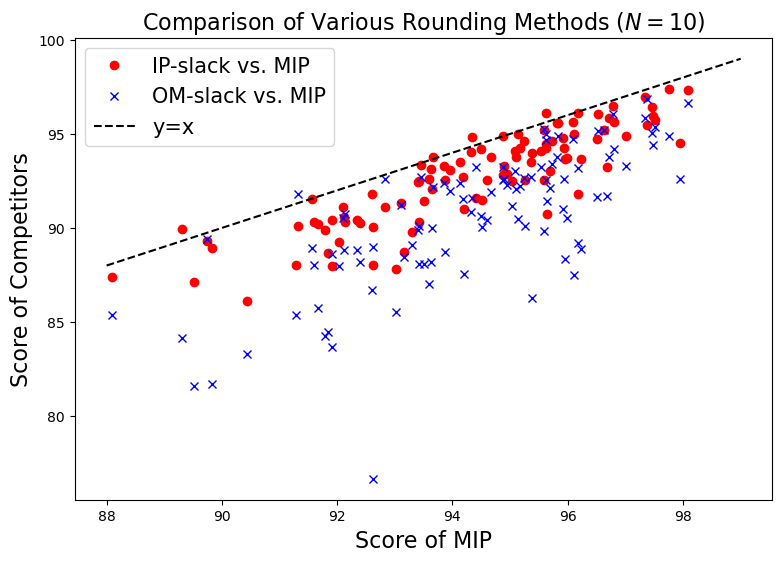

In [59]:
# Prepare data for plotting
v1_v2_points = [(result[0], result[1]) for result in results]
v1_v3_points = [(result[0], result[2]) for result in results]

# Plotting
plt.figure(figsize=(9, 6))

# Plot points (v1,v2) and (v1,v3)
for point in v1_v2_points:
    plt.plot(point[0], point[1], 'ro', label='IP-slack vs. MIP' if point == v1_v2_points[0] else "")
for point in v1_v3_points:
    plt.plot(point[0], point[1], 'bx', label='OM-slack vs. MIP' if point == v1_v3_points[0] else "")

# Plot line y=x
x = range(int(min(results)[0]), int(max(results)[0])+2)
plt.plot(x, x, 'k--', label='y=x')

# Labels and legend
plt.xlabel('Score of MIP',size=16)
plt.ylabel('Score of Competitors',size=16)
plt.title('Comparison of Various Rounding Methods ($N=10$)',size=16)
plt.legend(fontsize=15)

plt.savefig("perf2.pdf")
